In [4]:
%matplotlib inline

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import statsmodels.api as sm
from datetime import datetime as dt
from datetime import timedelta as td
from dateutil.relativedelta import relativedelta as rd

# NBER recessions
from pandas_datareader.data import DataReader


In [12]:
#pick a stock for the regime model based on users input ticker
#calculate intraday, overnight, and daily returns
def grabstock(symbol, years):
    end_date = dt.today().strftime('%Y-%m-%d')
    start_date = (dt.today() - td(days=years*365)).strftime('%Y-%m-%d')
    ticker = yf.Ticker(symbol)
    df = ticker.history(start=start_date, end=end_date)
    df['Intradayreturn'] = df.Close/df.Open-1
    overnightreturns = []
    df['overnight_return'] = (df.Open-df.Close)/df.Close
    df['daily_return'] = df['overnight_return'] + df['Intradayreturn']
    df['log_return'] = np.log(df['Close']/df['Close'].shift(1))
    df = df.dropna()
    #df['log_returns'] = log_returns
    return df

def start_regime(symbol):
    ticker = yf.Ticker(symbol)
    end_date = dt.today().strftime('%Y-%m-%d')
    start_date = (dt.today() - td(days=365)).strftime('%Y-%m-%d')
    df = ticker.history(start = start_date, end = end_date)
    df['log_return'] = np.log(df['Close']/df['Close'].shift(1))
    df = df.dropna()
    log_returns = df['log_return']
    mean = np.mean(log_returns)
    std = np.std(log_returns)
    mod_stock = sm.tsa.MarkovRegression(log_returns, k_regimes=2, switching_variance= True)
    res_stock = mod_stock.fit()
    params = res_stock.params
    if params[0] > params[1]:
        return 'bull', mean, std
    else:
        return 'bear', mean, std


def regime(symbol):
    ticker = yf.Ticker(symbol)
    df = ticker.history(period = 'max')
    first_last = df.iloc[[0, -1]]
    start_per = first_last.iloc[:,0].index[0]
    end_per = first_last.iloc[:,0].index[1]
    our_rate = first_last['Close'].iloc[-1]/first_last['Close'].iloc[0]
    #grab the SPY information for the same period
    sp500 = yf.Ticker('^GSPC')
    df2 = sp500.history(period = 'max')
    sp_per = df2.loc[(df2.index == start_per) | (df2.index == end_per)]
    sp_rate = sp_per['Close'].iloc[-1]/sp_per['Close'].iloc[0]
    #determine if stock outpaces spy over the same period of time (beats SP500)
    if our_rate >= sp_rate:
        return 0.7, 0.3, our_rate, sp_rate #bull case probabilities, following bull, bear
    else:
        return 0.3, 0.7, our_rate, sp_rate #bear case probabilities

start_regime('PEP')
stock = grabstock('^GSPC', 4)
#regim = regime('AAPL')
stock

/Users/zachazherman/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Intradayreturn,overnight_return,daily_return,log_return
Date,,,,,,,,,,,
2019-12-19 00:00:00-05:00,3192.320068,3205.479980,3192.320068,3205.370117,3784360000,0.0,0.0,0.004088,-0.004071,1.664331e-05,0.004449
2019-12-20 00:00:00-05:00,3223.330078,3225.649902,3216.030029,3221.219971,6457480000,0.0,0.0,-0.000655,0.000655,4.288288e-07,0.004933
2019-12-23 00:00:00-05:00,3226.050049,3227.780029,3222.300049,3224.010010,3064530000,0.0,0.0,-0.000632,0.000633,4.001377e-07,0.000866
2019-12-24 00:00:00-05:00,3225.449951,3226.429932,3220.510010,3223.379883,1296530000,0.0,0.0,-0.000642,0.000642,4.121616e-07,-0.000195
2019-12-26 00:00:00-05:00,3227.199951,3240.080078,3227.199951,3239.909912,2164540000,0.0,0.0,0.003938,-0.003923,1.545004e-05,0.005115
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-11 00:00:00-05:00,4593.390137,4623.709961,4593.390137,4622.439941,3823210000,0.0,0.0,0.006324,-0.006285,3.974494e-05,0.003917
2023-12-12 00:00:00-05:00,4618.299805,4643.930176,4608.089844,4643.700195,3808380000,0.0,0.0,0.005500,-0.005470,3.008392e-05,0.004589
2023-12-13 00:00:00-05:00,4646.200195,4709.689941,4643.229980,4707.089844,5063650000,0.0,0.0,0.013105,-0.012936,1.695261e-04,0.013558


In [13]:
dta = stock
dta

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Intradayreturn,overnight_return,daily_return,log_return
Date,,,,,,,,,,,
2019-12-19 00:00:00-05:00,3192.320068,3205.479980,3192.320068,3205.370117,3784360000,0.0,0.0,0.004088,-0.004071,1.664331e-05,0.004449
2019-12-20 00:00:00-05:00,3223.330078,3225.649902,3216.030029,3221.219971,6457480000,0.0,0.0,-0.000655,0.000655,4.288288e-07,0.004933
2019-12-23 00:00:00-05:00,3226.050049,3227.780029,3222.300049,3224.010010,3064530000,0.0,0.0,-0.000632,0.000633,4.001377e-07,0.000866
2019-12-24 00:00:00-05:00,3225.449951,3226.429932,3220.510010,3223.379883,1296530000,0.0,0.0,-0.000642,0.000642,4.121616e-07,-0.000195
2019-12-26 00:00:00-05:00,3227.199951,3240.080078,3227.199951,3239.909912,2164540000,0.0,0.0,0.003938,-0.003923,1.545004e-05,0.005115
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-11 00:00:00-05:00,4593.390137,4623.709961,4593.390137,4622.439941,3823210000,0.0,0.0,0.006324,-0.006285,3.974494e-05,0.003917
2023-12-12 00:00:00-05:00,4618.299805,4643.930176,4608.089844,4643.700195,3808380000,0.0,0.0,0.005500,-0.005470,3.008392e-05,0.004589
2023-12-13 00:00:00-05:00,4646.200195,4709.689941,4643.229980,4707.089844,5063650000,0.0,0.0,0.013105,-0.012936,1.695261e-04,0.013558


/Users/zachazherman/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


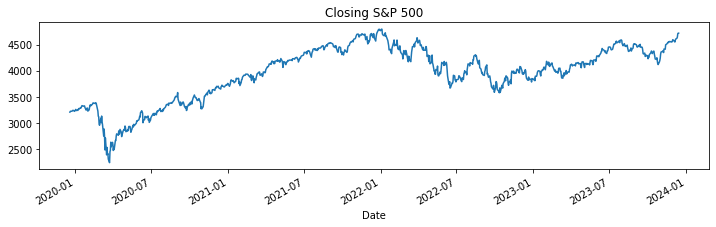

In [14]:
# Plot the data
ret = dta.Close
ret.plot(title="Closing S&P 500", figsize=(12, 3))

# Fit the model
mod_hamilton = sm.tsa.MarkovRegression(ret, k_regimes=2)
res_hamilton = mod_hamilton.fit()

In [15]:
res_hamilton.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1005
Model:               MarkovRegression   Log Likelihood               -7121.198
Date:                Sun, 17 Dec 2023   AIC                          14252.395
Time:                        20:16:59   BIC                          14276.959
Sample:                             0   HQIC                         14261.729
                               - 1005                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3250.1335     18.871    172.233      0.000    3213.148    3287.119
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4226.7295     11.089    381.152      0.000    4204.995    4248.464
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8.119e+04   3630.016     22.367      0.000    7.41e+04    8.83e+04
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9953      0.004    259.311      0.000       0.988       1.003
p[1->0]        0.0023      0.002      1.365      0.172      -0.001       0.006
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

# What we can Understand from the above:

We are given two constants, in Regime Switching model regarding stock price, <br>
the most basic example is a bull regime and a bear regime:<br>

Regime 0 corresponds to the 'low' regime according to statsmodel.api references which is our bear scenario, <br>
while Regime 1 corresponds to the 'high' regime which is our bull scenario

With a mean of approx. $3243 for the market value of the S and P 500, we can assume that this is the mean of a bear market<br>
on the contrary with a mean of approx. $4218 we can say this is the mean of a bull market<br>


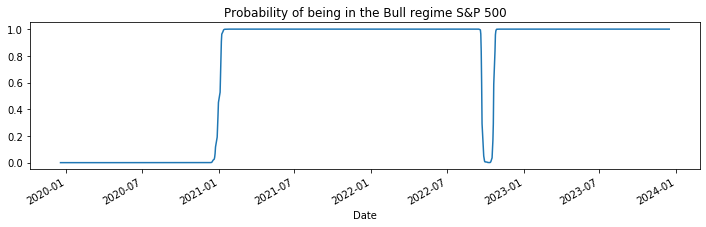

In [16]:
res_hamilton.smoothed_marginal_probabilities[1].plot(
    title="Probability of being in the Bull regime S&P 500", figsize=(12, 3)
)

### We can see that the bull periods matches what we know as the markets bull periods 

In [17]:
res_hamilton.expected_durations

array([210.861839  , 432.93526051])

##### The expected durations above returns how long we are in a bear market and bull market, respectively

We obtain this by dividing each by the number of days in a month resulting in : <br>
Approx 2 Years Bear<br>
Approx 2 Years Bull

### Changes using 3 regimes: 

Bear, Stagnant, Bull<br>


Notes:<br>
Poor visualization for market, <br>
ie market is rarely stagnant, so 3 regimes is a poor visualization

In [18]:
ret2 = dta.Close
#exog = pd.concat((dta.shift(), dta_ogap, dta_inf), axis=1).iloc[4:]
# Fit the model
mod_3 = sm.tsa.MarkovRegression(ret2, k_regimes=3)
res_3 = mod_3.fit(search_reps=20)
#print(res_3.summary())
#print(res_3.expected_durations)

/Users/zachazherman/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/zachazherman/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/regime_switching/markov_switching.py:1287: EstimationWarning: Invalid regime transition probabilities estimated in EM iteration; probabilities have been re-scaled to continue estimation.
  EstimationWarning)
/Users/zachazherman/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/regime_switching/markov_switching.py:1287: EstimationWarning: Invalid regime transition probabilities estimated in EM iteration; probabilities have been re-scaled to continue estimation.
  EstimationWarning)


In [19]:
res_3.summary()

/Users/zachazherman/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1354: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/Users/zachazherman/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/zachazherman/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/zachazherman/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1005
Model:               MarkovRegression   Log Likelihood               -7121.198
Date:                Sun, 17 Dec 2023   AIC                          14262.396
Time:                        20:17:09   BIC                          14311.523
Sample:                             0   HQIC                         14281.063
                               - 1005                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3194.4079      0.206   1.55e+04      0.000    3194.003    3194.812
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3250.2143     18.856    172.367      0.000    3213.257    3287.172
                             Regime 2 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4226.8828     11.084    381.360      0.000    4205.159    4248.606
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8.114e+04      0.001   8.59e+07      0.000    8.11e+04    8.11e+04
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.0006     96.101   6.26e-06      1.000    -188.353     188.354
p[1->0]             0        nan        nan        nan         nan         nan
p[2->0]     3.693e-11   8.93e-06   4.13e-06      1.000   -1.75e-05    1.75e-05
p[0->1]        0.9994     69.123      0.014      0.988    -134.479     136.478
p[1->1]        0.9953      0.004    260.217      0.000       0.988       1.003
p[2->1]        0.0023      0.002      1.365      0.172      -0.001       0.006
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 5.71e+24. Standard errors may be unstable.
"""

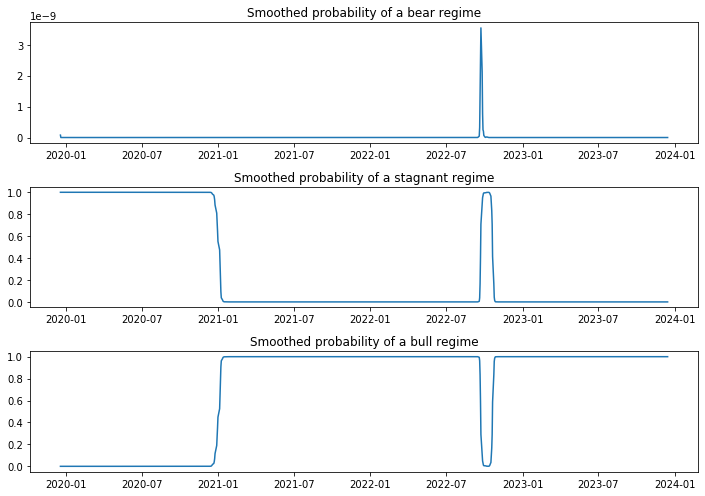

In [20]:
fig, axes = plt.subplots(3, figsize=(10, 7))

ax = axes[0]
ax.plot(res_3.smoothed_marginal_probabilities[0])
ax.set(title="Smoothed probability of a bear regime")

ax = axes[1]
ax.plot(res_3.smoothed_marginal_probabilities[1])
ax.set(title="Smoothed probability of a stagnant regime")

ax = axes[2]
ax.plot(res_3.smoothed_marginal_probabilities[2])
ax.set(title="Smoothed probability of a bull regime")

fig.tight_layout()

## Further steps: comparison to the other stocks vs market:

PEP, AAPL, GME <br>
We want to look at some cyclical stocks

In [21]:
#We use the same period as for S&P500 above: 4 years

pep = grabstock('PEP', 1)
aapl = grabstock('AAPL', 1)
atz = grabstock('CHWY', 1)

In [22]:
pep_close = pep.Close
aapl_close = aapl.Close
atz_close = atz.Close

# Fit the models
mod_pep = sm.tsa.MarkovRegression(pep_close, k_regimes=2)
res_pep = mod_pep.fit()

mod_aapl = sm.tsa.MarkovRegression(aapl_close, k_regimes=2)
res_aapl = mod_aapl.fit()

mod_atz = sm.tsa.MarkovRegression(atz_close, k_regimes=2)
res_atz = mod_atz.fit()

/Users/zachazherman/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/zachazherman/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/zachazherman/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [23]:
res_pep.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                  Close   No. Observations:                  249
Model:               MarkovRegression   Log Likelihood                -877.256
Date:                Sun, 17 Dec 2023   AIC                           1764.511
Time:                        20:17:16   BIC                           1782.098
Sample:                             0   HQIC                          1771.590
                                - 249                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        165.1270   4.17e-13   3.96e+14      0.000     165.127     165.127
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        174.7297      0.520    336.228      0.000     173.711     175.748
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        67.2457      6.027     11.158      0.000      55.434      79.058
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]     3.546e-11     96.732   3.67e-13      1.000    -189.590     189.590
p[1->0]      8.99e-21   9.42e-08   9.54e-14      1.000   -1.85e-07    1.85e-07
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 1.46e+31. Standard errors may be unstable.
"""

In [24]:
res_aapl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                  Close   No. Observations:                  249
Model:               MarkovRegression   Log Likelihood                -926.711
Date:                Sun, 17 Dec 2023   AIC                           1863.423
Time:                        20:17:17   BIC                           1881.010
Sample:                             0   HQIC                          1870.502
                                - 249                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        146.4624      2.002     73.167      0.000     142.539     150.386
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        180.3707      1.060    170.099      0.000     178.292     182.449
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        96.2229      8.672     11.096      0.000      79.227     113.219
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9947      0.007    142.311      0.000       0.981       1.008
p[1->0]        0.0035      0.004      0.867      0.386      -0.004       0.011
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [25]:
res_atz.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                  Close   No. Observations:                  249
Model:               MarkovRegression   Log Likelihood                -713.116
Date:                Sun, 17 Dec 2023   AIC                           1436.232
Time:                        20:17:18   BIC                           1453.819
Sample:                             0   HQIC                          1443.311
                                - 249                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.4550      0.462     44.279      0.000      19.550      21.360
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         37.4422      0.331    113.159      0.000      36.794      38.091
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        17.1954      1.545     11.129      0.000      14.167      20.224
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9951      0.006    155.471      0.000       0.983       1.008
p[1->0]        0.0036      0.004      0.858      0.391      -0.005       0.012
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

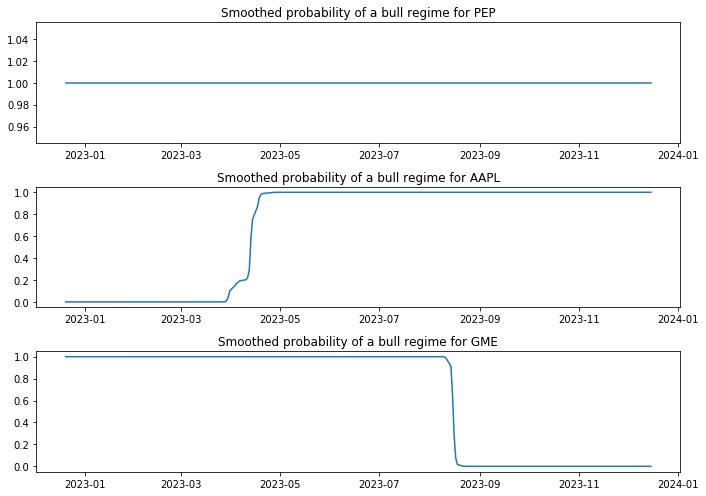

In [26]:
fig, axes = plt.subplots(3, figsize=(10, 7))

ax = axes[0]
ax.plot(res_pep.smoothed_marginal_probabilities[1])
ax.set(title="Smoothed probability of a bull regime for PEP")

ax = axes[1]
ax.plot(res_aapl.smoothed_marginal_probabilities[1])
ax.set(title="Smoothed probability of a bull regime for AAPL")

ax = axes[2]
ax.plot(res_atz.smoothed_marginal_probabilities[1])
ax.set(title="Smoothed probability of a bull regime for GME")

fig.tight_layout()

In [27]:
#Here we form markov regressions on each of the 3 stocks based on their returns
#We use the parameters as inputs for simulating the stock paths
pep_logret = pep.log_return
aapl_logret = aapl.log_return
atz_logret = atz.log_return

# Fit the models
mod_pep = sm.tsa.MarkovRegression(pep_logret, k_regimes=2)
res_pep = mod_pep.fit()

mod_aapl = sm.tsa.MarkovRegression(aapl_logret, k_regimes=2)
res_aapl = mod_aapl.fit()

mod_atz = sm.tsa.MarkovRegression(atz_logret, k_regimes=2)
res_atz = mod_atz.fit()

res_atz.params #shows calculated transition probabilities, mean, and overall var
#res_gme.params

/Users/zachazherman/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/zachazherman/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/zachazherman/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


p[0->0]     0.499157
p[1->0]     0.499700
const[0]   -0.002507
const[1]   -0.002773
sigma2      0.001148
dtype: float64

### Simulating stock values using calculated transition probabilities and mean and volatility of each regime

In [28]:
# Initial state
#standard normal gen for both regime switch and for gbm multiply by dependent mu and vol
num_sims = 100

def simulate_regime(ticker, num_sims, initial_price, num_days, mu_bull, mu_bear, vol_bull, vol_bear, p_bear_to_bear, p_bull_to_bear):
    simulated_prices = np.zeros((num_sims, num_days))
    current_regime = start_regime(ticker)
    for i in range(num_sims):
        current_state = current_regime
        daily_returns = np.zeros(num_days)
        for day in range(num_days):
            if current_state == "bull":
                return_bull = np.random.normal(mu_bull, vol_bull)
                daily_returns[day] = return_bull

                if np.random.rand() > p_bull_to_bear:
                    current_state = "bear"
            else:
                return_bear = np.random.normal(mu_bear, vol_bear)
                daily_returns[day] = return_bear

                if np.random.rand() > p_bear_to_bear:
                    current_state = "bull"
        simulated_prices[i] = initial_price * np.cumprod(1 + daily_returns)
    return simulated_prices

In [ ]:
def gbm(ticker, num_sims, initial_price, num_days, mu_bull, mu_bear, vol_bull, vol_bear, p_bear_to_bear, p_bull_to_bear):
    simulated_prices = np.zeros((num_sims, num_days))
    current_regime = start_regime(ticker)
    for i in range(num_sims):
        current_state = current_regime
        daily_returns = np.zeros(num_days)
        for day in range(num_days):
            if current_state == "bull":
                return_bull = np.random.normal(mu_bull, vol_bull)
                daily_returns[day] = return_bull

                if np.random.rand() > p_bull_to_bear:
                    current_state = "bear"
            else:
                return_bear = np.random.normal(mu_bear, vol_bear)
                daily_returns[day] = return_bear

                if np.random.rand() > p_bear_to_bear:
                    current_state = "bull"
        simulated_prices[i] = initial_price * np.cumprod(1 + daily_returns)
    return simulated_prices

/Users/zachazherman/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/zachazherman/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Mean of Final Stock Price: 139.57242222607175
Sigma of Final Stock Price: 36.87767835736661


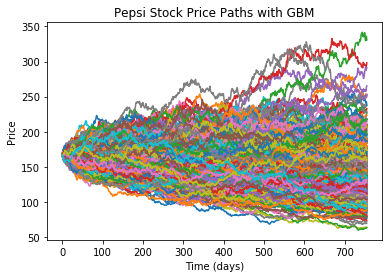

In [111]:

def gbm_stock_price(S0, mu, sigma, T, N, W):
    dt = T / N
    t = np.linspace(0, T, N+1)
    #W = np.random.standard_normal(size=N+1) 
    #print(W)
    W = np.cumsum(W)* np.sqrt(dt)  # Brownian motion
    X = (mu - 0.5 * sigma**2) * t + sigma * W  # GBM process
    S = S0 * np.exp(X)  # Stock price process
    S[0] = S0
    return S

num_sims = 500
T = 3
num_days = T*252
W = np.zeros((num_sims, num_days))
sim_gbm = np.zeros((num_sims, num_days))
stock = grabstock('PEP', T)
initial_price = stock['Close'].iloc[-1]
#print(stock.iloc[-1])
#print(initial_price)
mu = start_regime('PEP')[1]
sigma = start_regime('PEP')[2]
final_price = np.zeros(num_sims)
for i in range(num_sims):
    W[i] = np.random.standard_normal(size=num_days)
    sim_gbm[i] = gbm_stock_price(initial_price, mu*252, sigma*np.sqrt(252), T, num_days-1, W[i])
    final_price[i] = (sim_gbm[i][num_days-1])
mean_final_price = np.mean(final_price)
std_final_price = np.std(final_price)
print("Mean of Final Stock Price:", mean_final_price)
print("Sigma of Final Stock Price:", std_final_price)

#print(sim_gbm)

for i in range(num_sims):
    plt.plot(sim_gbm[i])


plt.title("Pepsi Stock Price Paths with GBM")
plt.xlabel("Time (days)")
plt.ylabel("Price")
plt.show()




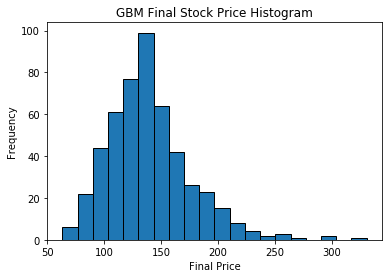

In [112]:
plt.hist(final_price, bins=20, edgecolor='black')  # Adjust the number of bins as needed
plt.title('GBM Final Stock Price Histogram')
plt.xlabel('Final Price')
plt.ylabel('Frequency')
plt.show()

/Users/zachazherman/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


167.0


/Users/zachazherman/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


p[0->0]      0.961309
p[1->0]      0.223930
const[0]     0.000715
const[1]    -0.002172
sigma2[0]    0.000072
sigma2[1]    0.000315
dtype: float64


/Users/zachazherman/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt


Mean of Final Stock Price: 182.69331177091738
Sigma of Final Stock Price: 97.85941657613424


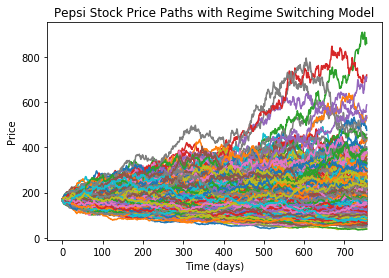

In [113]:
W1 = np.zeros((num_sims, num_days))
S1 = np.zeros((num_sims,num_days))
X1 = np.zeros((num_sims,num_days))
def regime_stock_price(S0, mu_bull, vol_bull, mu_bear, vol_bear, T, N, W, current_regime, p_bull_to_bear, p_bear_to_bear, num_sims):
    for i in range(num_sims):
        #t = np.linspace(0, T, N+1)
        S1[i][0] = S0
        for j in range(1,N):
            if current_regime == 'bull':
                dt = T / N
                #W1[i][j] = mu_bull + vol_bull*W[i][j]
                #W1[i][j] = W1[i][j] * np.sqrt(dt)  # Brownian motion
                X1[i][j] = (mu_bull - 0.5 * vol_bull**2) *dt + vol_bull * W[i][j]  # GBM process
                S1[i][j] = S1[i][j-1] * np.exp(X1[i][j])  # Stock price process
                if np.random.rand() > p_bull_to_bear:
                    current_state = "bear"
            else:
                dt = T / N
                #W1[i][j] = mu_bear + vol_bear*W[i][j]
                #W1[i][j] = W1[i][j] * np.sqrt(dt)  # Brownian motion
                X1[i][j] = (mu_bear - 0.5 * vol_bear**2) *dt + vol_bear * W[i][j]  # GBM process
                S1[i][j] = S1[i][j-1]* np.exp(X1[i][j])  # Stock price process
                if np.random.rand() > p_bear_to_bear:
                    current_state = "bull"
    
    return S1
            
    

stock = grabstock('PEP', T)
num_days = T*252
stock_logret = stock.log_return
mod_stock = sm.tsa.MarkovRegression(stock_logret, k_regimes=2, switching_variance= True)
res_stock = mod_stock.fit()
initial_price = stock['Close'].iloc[-1]
print(initial_price)
params = res_stock.params
current_regime = start_regime('PEP')[0]
print(params)


sim_regime = regime_stock_price(initial_price, params[2], np.sqrt(params[3]), params[4], np.sqrt(params[5]), T, num_days, W, current_regime, params[0], 1-params[1], num_sims)

for i in range(num_sims):
    final_price[i] = (sim_regime[i][num_days-1])
mean_final_price = np.mean(final_price)
std_final_price = np.std(final_price)
print("Mean of Final Stock Price:", mean_final_price)
print("Sigma of Final Stock Price:", std_final_price)

for i in range(num_sims):
    plt.plot(sim_regime[i])
plt.title("Pepsi Stock Price Paths with Regime Switching Model")
plt.xlabel("Time (days)")
plt.ylabel("Price")
plt.show()



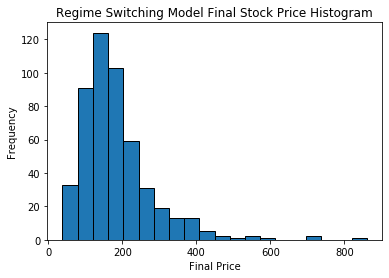

In [114]:
plt.hist(final_price, bins=20, edgecolor='black')  # Adjust the number of bins as needed
plt.title('Regime Switching Model Final Stock Price Histogram')
plt.xlabel('Final Price')
plt.ylabel('Frequency')
plt.show()

In [156]:
test = start_regime('PEP')
test[2]

sigma = test[2]
sigma

c:\Users\stefa\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


0.009434502184420662

In [169]:
t = np.linspace(0, 1, 9+1)
t

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

In [188]:
def gbm_stock_price2(S0, T, N, ticker, num_sims, mu_bull, mu_bear, vol_bull, vol_bear, p_bear_to_bear, p_bull_to_bear, seed=None):
    current_regime = start_regime(ticker)
    current_state = current_regime[0]
    S = np.zeros((num_sims, N+1))
    S1 = np.zeros((num_sims, N+1))
    S1[0] = S0
    S[0] = S0
    for i in range(1,num_sims):

        #GBM model
        np.random.seed(seed)
        dt = T / N
        t = np.linspace(0, T, N+1)
        std_norm = np.random.standard_normal(size=N+1) 
        #print(std_norm)
        W = np.cumsum(std_norm) * np.sqrt(dt)  # Brownian motion
        X = (0.06 - 0.5 * sigma**2)*t + sigma * W  # GBM process
        S[i] = S[i-1] * np.exp(X)  # Stock price process

        #Regime Switch Model
        W1 = np.zeros(N)
        X1 = np.zeros(N)
        for day in range(1,N):
            if current_state == "bull":
                return_bull = mu_bull + vol_bull*std_norm[day]
                W1[day] = return_bull * np.sqrt(dt)  # Brownian motion
                X1[day] = (0.06 - 0.5 * vol_bull**2) * dt + vol_bull * W1[day]  # GBM process
                S1[i][day] = S1[i][day-1] * np.exp(X1[day])
                if np.random.rand() > p_bull_to_bear:
                    current_state = "bear"
            else:
                return_bear = mu_bear + vol_bear*std_norm[day]
                W1[day] = return_bear * np.sqrt(dt)  # Brownian motion
                X1[day] = (0.06 - 0.5 * vol_bear**2) * dt + vol_bear * W1[day]  # GBM process
                S1[i][day] = S1[i][day-1] * np.exp(X1[day])
                if np.random.rand() > p_bear_to_bear:
                    current_state = "bull"
        
    return S, S1



In [140]:
num_sims = 100
def gbm_and_regime(ticker, num_sims, initial_price, num_days, mu_bull, mu_bear, vol_bull, vol_bear, p_bear_to_bear, p_bull_to_bear):
    #initial_price2 = initial_price
    simulated_prices = np.zeros((num_sims, num_days))
    current_regime = start_regime(ticker)
    gbm_prices = np.zeros((num_sims, num_days))
    current_state = current_regime[0] #the state, bull or bear
    #print(current_regime[1], current_regime[2])
    print(initial_price)
    
    for i in range(num_sims):
        #standard_normal = np.random.standard_normal()
        standard_normal = np.random.standard_normal()
        print(standard_normal)
        current_state = current_regime
        daily_returns = np.zeros(num_days)
        gbm_returns = np.zeros(num_days)
        for day in range(num_days):
            gbm_returns[day] = standard_normal
            if current_state == "bull":
                return_bull = mu_bull + vol_bull*standard_normal
                daily_returns[day] = return_bull

                if np.random.rand() > p_bull_to_bear:
                    current_state = "bear"
            else:
                return_bear = mu_bear+ vol_bear*standard_normal
                daily_returns[day] = return_bear

                if np.random.rand() > p_bear_to_bear:
                    current_state = "bull"
        simulated_prices[i] = initial_price * np.cumprod(1 + daily_returns)
        gbm_prices[i] = initial_price * np.cumprod(1 + gbm_returns)
        print(gbm_prices[i][0])
    return simulated_prices

In [189]:
def stock_vals(ticker, years):
    stock = grabstock(ticker, years)
    num_days = years*252
    stock_logret = stock.log_return
    mod_stock = sm.tsa.MarkovRegression(stock_logret, k_regimes=2, switching_variance= True)
    res_stock = mod_stock.fit()
    initial_price = stock['Close'].iloc[0]
    params = res_stock.params
    print(params)
    return gbm_stock_price2(initial_price, years, num_days, ticker, num_sims, params[2], params[3], np.sqrt(params[4]), np.sqrt(params[5]), 1-params[1], params[0], seed=None)
    #return gbm_and_regime(ticker, num_sims, initial_price, num_days , params[2], params[3], np.sqrt(params[4]), np.sqrt(params[5]), 1-params[1], params[0])


sim_pep = stock_vals('PEP', 2)
#sim_pep
#regime = sim_pep[0]
#gbm = sim_pep[1]
#gbm



c:\Users\stefa\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


p[0->0]      0.971423
p[1->0]      0.158897
const[0]     0.000547
const[1]    -0.002764
sigma2[0]    0.000077
sigma2[1]    0.000359
dtype: float64


c:\Users\stefa\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


[ 1.20747829e+00 -1.11463043e+00  8.73531573e-02  1.70685558e-01
 -1.07175162e+00 -3.89877748e-01 -1.78030511e+00  1.60694868e+00
  3.91805511e-01  3.71049628e-01 -1.57946340e-01  1.43158740e+00
  1.36544987e-01 -1.44303120e+00 -6.97393674e-01 -1.12246655e+00
 -1.73013322e+00  3.73441985e-01  1.09054292e+00  3.53822084e-01
 -6.49154847e-01  1.69906761e-01 -1.00132958e+00  2.31996826e-02
  7.15750967e-02  1.60402059e-01  1.40821672e+00 -2.76134271e-01
  2.57112338e-01 -2.80837433e-01 -1.68529798e+00 -9.82020703e-01
  1.02812956e-01 -8.51375312e-01  5.12283424e-02  2.36941248e+00
 -3.06329768e-01 -7.04522822e-01  4.30404996e-01  6.88153044e-01
  2.06538935e+00  2.54603294e-01  6.42697087e-01 -5.04333152e-01
 -1.06369771e+00 -7.66357667e-01 -9.69364136e-01 -1.04618420e+00
 -2.17102995e+00  1.22007619e+00 -1.49393971e-01  5.12745028e-01
 -9.61718597e-01  4.18364442e-01  3.49181044e-01 -3.56666070e-01
  7.90604320e-02  3.21553041e-01 -1.91407041e+00  2.00407128e+00
  1.08706664e-01 -3.62920

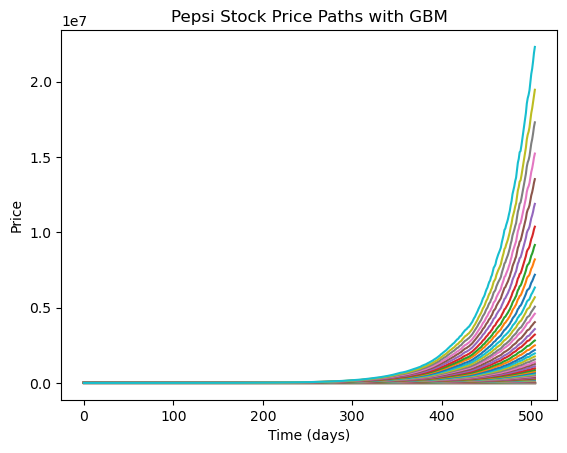

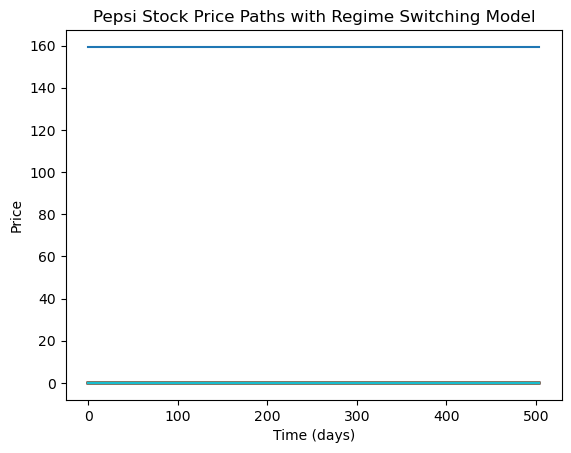

In [187]:
gbm = sim_pep[0]
regime = sim_pep[1]

for i in range(100):
    plt.plot(gbm[i])
plt.title("Pepsi Stock Price Paths with GBM")
plt.xlabel("Time (days)")
plt.ylabel("Price")
plt.show()

for i in range(100):
    plt.plot(regime[i])
plt.title("Pepsi Stock Price Paths with Regime Switching Model")
plt.xlabel("Time (days)")
plt.ylabel("Price")
plt.show()

In [8]:
num_stocks = 3

mu_bull = [0]*num_stocks
mu_bear = [0]*num_stocks
vol_bull = [0]*num_stocks
vol_bear = [0]*num_stocks
p_bear_to_bear = [0]*num_stocks
p_bull_to_bear = [0]*num_stocks
#for i in range(num_stocks):
    #if i == 0:
p_bear_to_bear[0] = res_aapl.params[0]
p_bull_to_bear[0] = 1-res_aapl.params[1]
mu_bear[0] = res_aapl.params[2]
mu_bull[0] = res_aapl.params[3]
vol_bull[0] = np.sqrt(res_aapl.params[4])+np.sqrt(res_aapl.params[4])/2
vol_bear[0] = np.sqrt(res_aapl.params[4])-np.sqrt(res_aapl.params[4])/2
sim_pep = simulate(num_sims, initial_price, num_days, mu_bull[0], mu_bear[0], vol_bull[0], vol_bear[0], p_bear_to_bear[0], p_bull_to_bear[0])
print(mu_bear[0], mu_bull[0], vol_bull[0], vol_bear[0], p_bear_to_bear[0], p_bull_to_bear[0])
    #if i == 1:
       # p_bear_to_bear[i] = res_aapl.params[0]
        #p_bull_to_bear[i] = res_aapl.params[1]
        #mu_bear[i] = res_aapl.params[2]
        #mu_bull[i] = res_aapl.params[3]
        #vol_bull[i] = np.sqrt(res_aapl.params[4])+np.sqrt(res_aapl.params[4])/2
        #vol_bear[i] = np.sqrt(res_aapl.params[4])-np.sqrt(res_aapl.params[4])/2
        #sim_aapl =  simulate(num_sims, initial_price, num_days, mu_bull[i], mu_bear[i], vol_bull[i], vol_bear[i], p_bear_to_bear[i], p_bull_to_bear[i])

    #if i == 2:
        #p_bear_to_bear[i] = res_gme.params[0]
        #p_bull_to_bear[i] = res_gme.params[1]
        #mu_bear[i] = res_gme.params[2]
        #mu_bull[i] = res_gme.params[3]
        #vol_bull[i] = np.sqrt(res_gme.params[4])+np.sqrt(res_gme.params[4])/2
        #vol_bear[i] = np.sqrt(res_gme.params[4])-np.sqrt(res_gme.params[4])/2
        #sim_gme =  simulate(num_sims, initial_price, num_days, mu_bull[i], mu_bear[i], vol_bull[i], vol_bear[i], p_bear_to_bear[i], p_bull_to_bear[i])

sim_aapl = simulate(num_sims, initial_price, num_days, mu_bull[0], mu_bear[0], vol_bull[0], vol_bear[0], p_bear_to_bear[0], p_bull_to_bear[0])

sim_atz = simulate(num_sims, initial_price, num_days, mu_bull[0], mu_bear[0], vol_bull[0], vol_bear[0], p_bear_to_bear[0], p_bull_to_bear[0])




NameError: name 'res_aapl' is not defined

In [108]:
#np.cumprod(1 + daily_returns) 
#sim_aapl == sim_pep


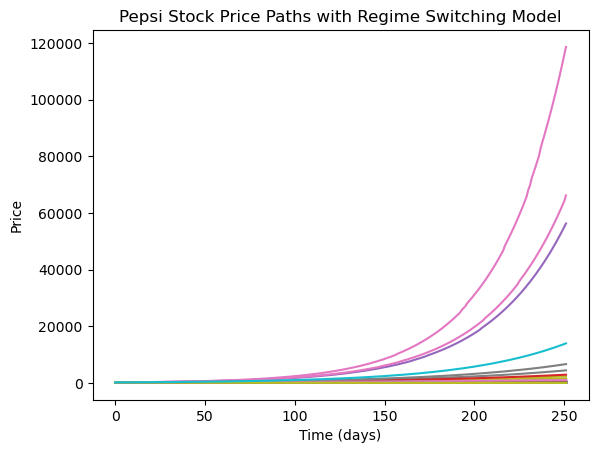

In [142]:
for i in range(100):
    plt.plot(sim_pep[i])
plt.title("Pepsi Stock Price Paths with Regime Switching Model")
plt.xlabel("Time (days)")
plt.ylabel("Price")
plt.show()

In [42]:
for i in range(100):
    plt.plot(gbm[i])
plt.title("Pepsi Stock Price Paths with Regime Switching Model")
plt.xlabel("Time (days)")
plt.ylabel("Price")
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

<Figure size 640x480 with 1 Axes>

In [30]:
for i in range(num_sims):
    plt.plot(sim_aapl[i])
plt.title("Apple Stock Price Paths with Regime Switching Model")
plt.xlabel("Time (days)")
plt.ylabel("Price")
plt.show()

NameError: name 'sim_aapl' is not defined

## The links for statsmodels.api:
https://www.statsmodels.org/dev/examples/notebooks/generated/markov_regression.html

https://www.statsmodels.org/stable/examples/notebooks/generated/markov_autoregression.html